In [309]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, LineString, Point

## Creating the delivery Locations

In [310]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [311]:
def create_polygon(points):
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    return obstacle

In [312]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [313]:
def initial_plot(delivery_loc, obstacles):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Delivery Locations")
    plt.show()

In [314]:
def clusters_plot(clusters, centroids, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("After Clustering")
    plt.show()

In [315]:
def dp_plot(clusters, centroids, dp, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("After DP Creation")
    plt.show()

In [316]:
def final_plot(delivery_loc,clusters, dp, obstacles):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])
        # plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Final Result")
    plt.show()

## KMeans Clustering

In [317]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [318]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [319]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [320]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line.intersects(obs):
            return False
    return True

In [321]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.001
    increment = 0.001
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

<font color="red">Try</font>

In [322]:
import networkx as nx

def create_shortest_path(point_1, point_2, obstacles):
    route_line = LineString([point_1, point_2])

    intersections = []
    for obstacle in obstacles:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(start)
                intersections.append(end)

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for i in range(len(intersections)):
        point = intersections[i]
        pt_1 = (point[0] + 0.001, point[1])
        pt_2 = (point[0] - 0.001, point[1])
        pt_3 = (point[0], point[1] - 0.001)
        pt_4 = (point[0], point[1] + 0.001)
        pts = [pt_1, pt_2, pt_3, pt_4]

        for pt in pts:
            flag = True
            for obs in obstacles:
                if Point(pt[0], pt[1]).intersects(obs):
                    flag = False
                    break
            if flag:
                G.add_node(pt)
    
    G.add_node(tuple(point_2))

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if is_obstacle_free(line, obstacles):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    return path

In [323]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      # intermediate_point = find_inter_point(point_a, point_b, obstacles)
      intermediate_point = create_shortest_path(point_a, point_b, obstacles)
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [324]:
def create_distance_matrix(points,dp,obstacles):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
            if inter != None:
                inter_matrix[(src_point, dest_point)] = inter
    
    return matrix, inter_matrix

In [325]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster,dp, obstacles)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end

## Main

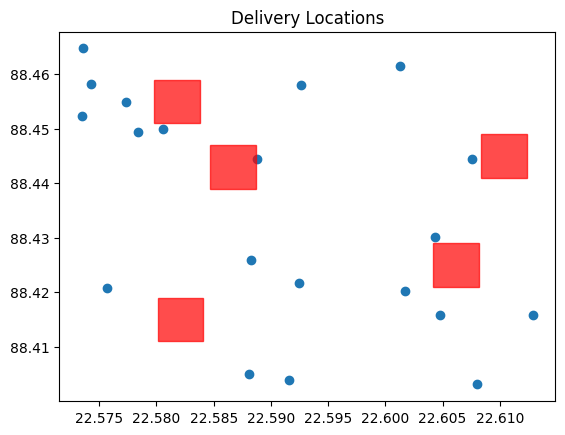

In [326]:
#no of delivery locations and drone capacity
n = 20
k = 5

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
delivery_loc = create_locations(x, y, n)

# obstacles
obstacles = {
    0 : [[22.5801, 88.4110],[22.5841, 88.4190]],
    1 : [[22.6042, 88.4210],[22.6082, 88.4290]],
    2 : [[22.6084, 88.4410],[22.6124, 88.4490]],
    3 : [[22.5798, 88.4510],[22.5838, 88.4590]],
    4 : [[22.5847, 88.4390],[22.5887, 88.4470]],
}

delivery_loc = verify_locations(delivery_loc, obstacles)

# Visualize the data
initial_plot(delivery_loc, obstacles)

{0: [[22.5743, 88.4581], [22.5784, 88.4493], [22.5735, 88.4523], [22.5773, 88.4548], [22.5736, 88.4647]], 1: [[22.6013, 88.4614], [22.6076, 88.4445], [22.5888, 88.4444], [22.5926, 88.458], [22.5806, 88.4499]], 2: [[22.6129, 88.4158], [22.6017, 88.4202], [22.6043, 88.4301], [22.6048, 88.4159], [22.608, 88.4031]], 3: [[22.5925, 88.4217], [22.5883, 88.4259], [22.5757, 88.4208], [22.5881, 88.405], [22.5916, 88.4039]]}


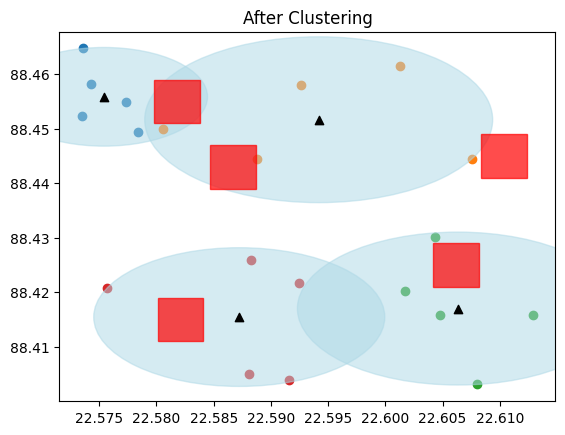

In [327]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

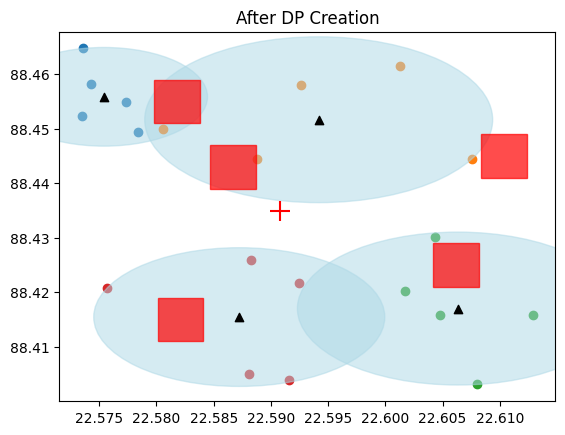

In [328]:
# Calculate DP
DP = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, DP, obstacles)

In [329]:
# Shortest path calculation in each cluster
for i in clusters:
    clusters[i] = tsp_brut(clusters[i], DP, obstacles)


Optimal path [[22.590795, 88.43499], [22.5735, 88.4523], [22.5743, 88.4581], [22.5736, 88.4647], [22.5773, 88.4548], [22.5784, 88.4493], [22.590795, 88.43499]] optimal distance 0.07331570457936312
Optimal path [[22.590795, 88.43499], [22.5888, 88.4444], [22.5806, 88.4499], [22.5926, 88.458], [22.6013, 88.4614], [22.6076, 88.4445], [22.590795, 88.43499]] optimal distance 0.08304863656033856
Optimal path [[22.590795, 88.43499], [22.6043, 88.4301], [22.6129, 88.4158], [22.608, 88.4031], [22.6048, 88.4159], [22.6017, 88.4202], [22.590795, 88.43499]] optimal distance 0.08357674315188895
Optimal path [[22.590795, 88.43499], [22.5757, 88.4208], [22.5881, 88.405], [22.5916, 88.4039], [22.5925, 88.4217], [22.5883, 88.4259], [22.590795, 88.43499]] optimal distance 0.07867080868612288


In [330]:
for i in clusters:
    print("Path",i,":")
    for j in clusters[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
[22.590795, 88.43499] -> (22.5837, 88.439) -> [22.5735, 88.4523] -> [22.5743, 88.4581] -> [22.5736, 88.4647] -> [22.5773, 88.4548] -> [22.5784, 88.4493] -> (22.5847, 88.43799999999999) -> [22.590795, 88.43499] -> End
Path 1 :
[22.590795, 88.43499] -> [22.5888, 88.4444] -> (22.5887, 88.44800000000001) -> [22.5806, 88.4499] -> (22.5848, 88.451) -> [22.5926, 88.458] -> [22.6013, 88.4614] -> [22.6076, 88.4445] -> [22.590795, 88.43499] -> End
Path 2 :
[22.590795, 88.43499] -> [22.6043, 88.4301] -> (22.6092, 88.429) -> [22.6129, 88.4158] -> [22.608, 88.4031] -> [22.6048, 88.4159] -> [22.6017, 88.4202] -> [22.590795, 88.43499] -> End
Path 3 :
[22.590795, 88.43499] -> [22.5757, 88.4208] -> (22.5801, 88.41) -> [22.5881, 88.405] -> [22.5916, 88.4039] -> [22.5925, 88.4217] -> [22.5883, 88.4259] -> [22.590795, 88.43499] -> End


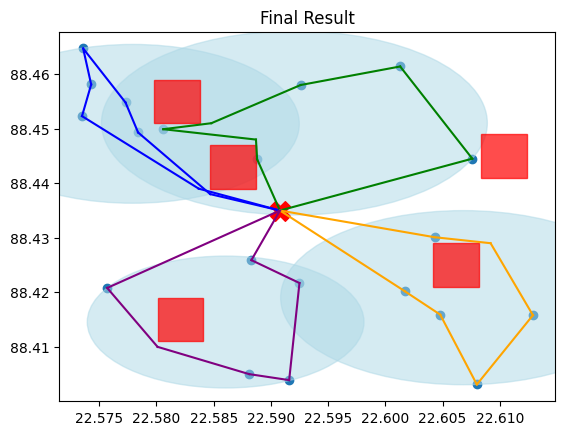

In [331]:
# Final Visualization
final_plot(delivery_loc,clusters, DP, obstacles)

## Calculate Total DIstance

In [332]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

*Total distance in manhattan cluster*

In [333]:
dist = total_distance(clusters)
print("Distance using manhattan cluster :",dist)

Distance using manhattan cluster : 0.3186118929777135


## Hold

In [334]:
from itertools import permutations

def tsp_brut(cluster, dp):
    path = list(permutations(cluster))
    cost = []
    # add dp at the start and end
    for i in range(len(path)):
        path[i] = list(path[i])
        path[i].append(dp)
        path[i].insert(0, dp)

        # Calculate distance
        points = path[i]
        sum = 0

        for j in range(len(points)-1):
            sum += calculate_distance(points[j], points[j+1])
        cost.append(sum)

    idx = np.argmin(cost)
    return path[idx]

In [335]:
lst = [1.2,2.3,3.4,4.5,5.6,6.7]
paths = list(permutations(lst))
print(list(paths[0]))

[1.2, 2.3, 3.4, 4.5, 5.6, 6.7]


In [336]:
example = {
    2 : "hi",
    3 : "hello"
}

num = 3

if example.get(3):
    print("Exist")

Exist


In [337]:
def final_plot(clusters, dp, obstacles):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    for i in clusters:
        pts = np.array(clusters[i])
        plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Final Result")
    plt.show()